Import thư viện

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from hmmlearn.hmm import GMMHMM


Load data

In [28]:
df = pd.read_csv(r'E:\3.IS403\Đồ án\Dataset final\Apple_clean.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200
5,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.363665,447610800
6,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.307527,462229600
7,2010-01-12,7.471071,7.491786,7.372143,7.418571,6.235778,594459600
8,2010-01-13,7.423929,7.533214,7.289286,7.523214,6.323737,605892000
9,2010-01-14,7.503929,7.516429,7.465000,7.479643,6.287113,432894000


Data preprocessing

In [30]:
df.columns = [c.strip().replace(' ', '_') for c in df.columns]
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df['LogReturn'] = np.log(df['Close']).diff()
df['Volatility'] = df['LogReturn'].rolling(20).std() * np.sqrt(252)
df = df.dropna(subset=['LogReturn','Volatility']).reset_index(drop=True)
# Show Dataframe
df

,Date,Open,High,Low,Close,Adj_Close,Volume,LogReturn,Volatility
0,2010-03-02,7.497500,7.529643,7.419286,7.458929,6.269701,566546400,-0.000670,0.227958
1,2010-03-03,7.462143,7.495357,7.426429,7.476071,6.284110,372052800,0.002296,0.227830
2,2010-03-04,7.474286,7.532857,7.451071,7.525357,6.325539,366041200,0.006571,0.222422
3,2010-03-05,7.676429,7.846429,7.665357,7.819643,6.572905,899620400,0.038361,0.204466
4,2010-03-08,7.857500,7.860357,7.794643,7.824286,6.576807,429889600,0.000594,0.201166
...,...,...,...,...,...,...,...,...,...
3937,2025-10-23,259.940002,260.619995,258.010010,259.579987,259.579987,32754900,0.004363,0.230740
3938,2025-10-24,261.190002,264.130005,259.179993,262.820007,262.820007,38253700,0.012405,0.233276
3939,2025-10-27,264.880005,269.119995,264.649994,268.809998,268.809998,44888200,0.022535,0.243860
3940,2025-10-28,268.989990,269.890015,268.149994,269.000000,269.000000,41461500,0.000707,0.243868


Chia Train / Validation / Test

In [18]:
T = len(df)
n_train = int(0.6 * T)
n_val   = int(0.2 * T)

df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train:n_train+n_val].copy()
df_test  = df.iloc[n_train+n_val:].copy()

def X_from(d): 
    return d[['LogReturn','Volatility']].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_from(df_train))
X_val   = scaler.transform(X_from(df_val))
X_test  = scaler.transform(X_from(df_test))


Huấn luyện mô hình HMM 6-2-2

In [19]:
model = GMMHMM(n_components=6, n_mix=2, covariance_type='diag', n_iter=300, random_state=42)
model.fit(X_train, [len(X_train)])

# Trung bình log-return cho từng trạng thái
mix_means_scaled = np.array([[model.means_[s][m] for m in range(model.n_mix)] for s in range(model.n_components)])
state_means_scaled = (model.weights_[...,None] * mix_means_scaled).sum(1)
state_means_orig = scaler.inverse_transform(state_means_scaled)
state_E_ret = state_means_orig[:,0]


Tạo dự báo Validation & Test

In [ ]:
def exp_returns_from_post(X_scaled):
    gamma = model.predict_proba(X_scaled)
    return gamma @ state_E_ret

def rebuild_prices(start_price, exp_returns):
    return start_price * np.exp(np.cumsum(exp_returns))

# Dự báo
pred_train = rebuild_prices(df_train['Close'].iloc[0], exp_returns_from_post(X_train))
pred_val   = rebuild_prices(df_train['Close'].iloc[-1], exp_returns_from_post(X_val))
pred_test  = rebuild_prices(df_val['Close'].iloc[-1],   exp_returns_from_post(X_test))

# 30 ngày
gamma_last = model.predict_proba(X_test)[-1]
state_dist = gamma_last.copy()
pred30_returns = []
for _ in range(30):
    pred30_returns.append(state_dist @ state_E_ret)
    state_dist = state_dist @ model.transmat_
pred30_prices = rebuild_prices(df_test['Close'].iloc[-1], np.array(pred30_returns))

print("Đã tạo xong: pred_train, pred_val, pred_test, pred30_prices")


Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance


Đã tạo xong: pred_train, pred_val, pred_test, pred30_prices


Evaluate in validation set

In [13]:
y_val_act = df_val['Close'].values
y_val_pred = pred_val

val_mape = mean_absolute_percentage_error(y_val_act, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val_act, y_val_pred))
val_msle = mean_squared_log_error(y_val_act, y_val_pred)

print("Validation metrics:")
print(f"MAPE: {val_mape:.6f}")
print(f"RMSE: {val_rmse:.6f}")
print(f"MSLE: {val_msle:.8f}")


Validation metrics:
MAPE: 0.411731
RMSE: 63.200710
MSLE: 0.39227568


Vẽ biểu đồ so sánh

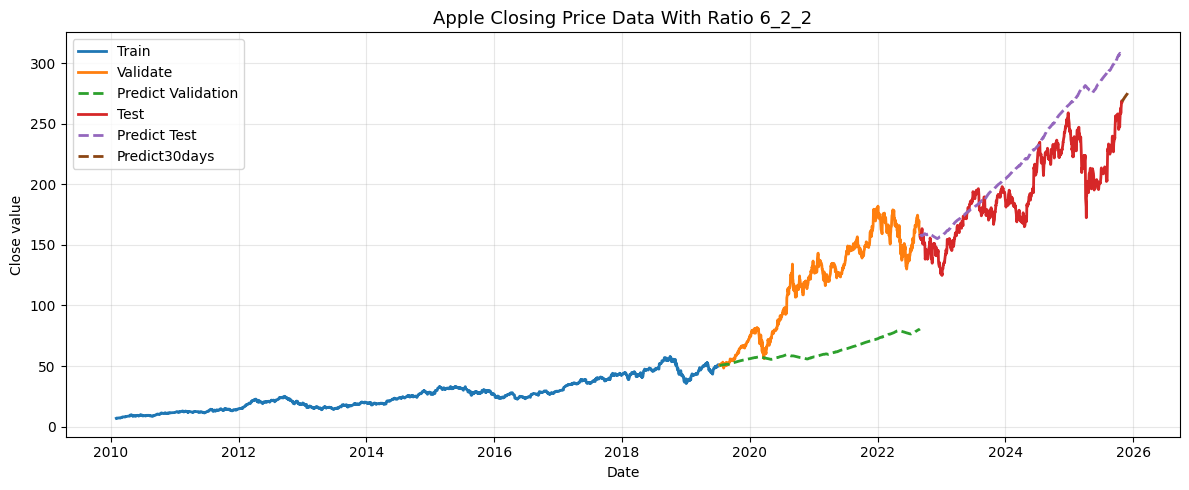

In [31]:

plt.figure(figsize=(12,5))

# --- Actual data (solid lines) ---
plt.plot(df_train['Date'], df_train['Close'], label='Train', color='tab:blue', linewidth=2)
plt.plot(df_val['Date'],   df_val['Close'],   label='Validate', color='tab:orange', linewidth=2)
plt.plot(df_test['Date'],  df_test['Close'],  label='Test', color='tab:red', linewidth=2)

# --- Predicted data (dashed lines) ---
plt.plot(df_val['Date'],  pred_val,   label='Predict Validation', color='tab:green', linewidth=2, linestyle='--')
plt.plot(df_test['Date'], pred_test,  label='Predict Test', color='tab:purple', linewidth=2, linestyle='--')
plt.plot(dates30,         pred30_prices, label='Predict30days', color='saddlebrown', linewidth=2, linestyle='--')

# --- Title, axes, grid ---
plt.title("Apple Closing Price Data With Ratio 6_2_2", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Close value")
plt.grid(True, alpha=0.3)

# --- Legend (order + style like CTLT) ---
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 3, 2, 4, 5]  # đúng thứ tự: Train, Validate, Predict Validation, Test, Predict Test, Predict30days
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left', frameon=True)

plt.tight_layout()
plt.show()
